In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model, Model

%matplotlib inline

In [2]:
image_dir_basepath = '../data/images/'
names = ['3', '29', '35'] # three type of fish (3: 鬼頭刀, 29: 赤筆, 35: 龍頭鷹哥魚)
image_size = 224

In [3]:
# load my fish ResNet-50 classifier
model_path = '../model/model-resnet50-final.h5' 
model_original = load_model(model_path)

# exclude the dense layer which outputs the class of fish
input = model_original.input
output = model_original.layers[-2].output
model = Model(input, output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
'''
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y
'''

"\ndef prewhiten(x):\n    if x.ndim == 4:\n        axis = (1, 2, 3)\n        size = x[0].size\n    elif x.ndim == 3:\n        axis = (0, 1, 2)\n        size = x.size\n    else:\n        raise ValueError('Dimension should be 3 or 4')\n\n    mean = np.mean(x, axis=axis, keepdims=True)\n    std = np.std(x, axis=axis, keepdims=True)\n    std_adj = np.maximum(std, 1.0/np.sqrt(size))\n    y = (x - mean) / std_adj\n    return y\n"

In [5]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [6]:
def load_images(filepaths):
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
        
    return np.array(aligned_images)

In [7]:
def calc_embs(filepaths, batch_size=1):
    aligned_images = load_images(filepaths)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    
    return embs

In [8]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [9]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

0.12731578946113586


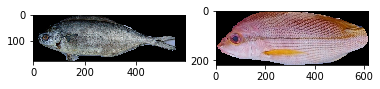

In [10]:
calc_dist_plot('30', '290')

0.11166682094335556


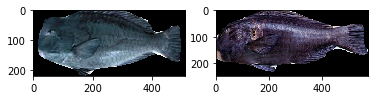

In [11]:
calc_dist_plot('350', '351')

# plot

In [12]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

> The below cell has **Technical debt** problem.

In [13]:
X_3 = []
X_29 = []
X_35 = []
for k, v in data.items():
    if '35' in k: # <-- technical debt here
        X_35.append(v['emb'])
    elif '29' in k:
        X_29.append(v['emb'])
    elif '3' in k: # <-- technical debt here
        X_3.append(v['emb'])
        
Xd_3 = pca.transform(X_3)
Xd_29 = pca.transform(X_29)
Xd_35 = pca.transform(X_35)

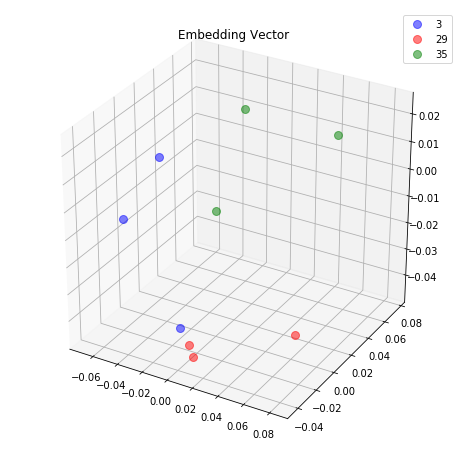

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10
ax.plot(Xd_3[:,0], Xd_3[:,1], Xd_3[:,2],
       'o', markersize=8, color='blue', alpha=0.5, label='3')
ax.plot(Xd_29[:,0], Xd_29[:,1], Xd_29[:,1],
       'o', markersize=8, color='red', alpha=0.5, label='29')
ax.plot(Xd_35[:,0], Xd_35[:,1], Xd_35[:,2],
       'o', markersize=8, color='green', alpha=0.5, label='35')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()